# Analysis of segments and marketing personae associated

In [5]:
# importations
import pandas as pd
import numpy as np
import os
import io
import s3fs
import re
import pickle
import warnings
import matplotlib.pyplot as plt

In [19]:
def load_model(type_of_activity, model):
    #BUCKET = f"projet-bdc2324-team1/Output_model/{type_of_activity}/{model}/"
    BUCKET = f"projet-bdc2324-team1/2_Output/2_1_Modeling_results/standard/{type_of_activity}/{model}/"
    filename = model + '.pkl'
    file_path = BUCKET + filename
    with fs.open(file_path, mode="rb") as f:
        model_bytes = f.read()

    model = pickle.loads(model_bytes)
    return model


def load_test_file(type_of_activity):
    #file_path_test = f"projet-bdc2324-team1/Generalization/{type_of_activity}/Test_set.csv"
    file_path_test = f"projet-bdc2324-team1/1_Temp/1_0_Modelling_Datasets/{type_of_activity}/Test_set.csv"
    with fs.open(file_path_test, mode="rb") as file_in:
        dataset_test = pd.read_csv(file_in, sep=",")
    return dataset_test

In [12]:
# exec(open('utils_segmentation.py').read())
warnings.filterwarnings('ignore')

# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

# choose the type of companies for which you want to run the pipeline
type_of_activity = "sport"

In [24]:
# load test set
dataset_test = load_test_file(type_of_activity)

# Load Model 
model = load_model(type_of_activity, 'LogisticRegression_Benchmark')

In [25]:
dataset_test

customer_id  street_id  structure_id  mcp_contact_id  fidelity  \
0       5_4317407     969908           NaN       6156473.0         1   
1        5_477635     109121           NaN       6213652.0         2   
2        5_411639      92929           NaN       6160271.0         4   
3        5_326623      79862           NaN       6140109.0         1   
4        5_383915      85421           NaN       6149409.0         2   
...           ...        ...           ...             ...       ...   
96091     9_91205      76215           NaN         47280.0         0   
96092    9_369887     815891           NaN      30764537.0         4   
96093   9_1007562          1           NaN             NaN         0   
96094     9_15037      12992           NaN       2213448.0         0   
96095    9_135370      76215           NaN       2164740.0         0   

       tenant_id  is_partner  deleted_at  is_email_true  opt_in  ...  \
0           1771       False         NaN           True       0  ...   
1           1771       False         NaN           True       0  ...   
2           1771       False         NaN           True       0  ...   
3           1771       False         NaN           True       1  ...   
4           1771       False         NaN           True       1  ...   
...          ...         ...         ...            ...     ...  ...   
96091       1490       False         NaN           True       1  ...   
96092       1490       False         NaN           True       0  ...   
96093       1490       False         NaN           True       0  ...   
96094       1490       False         NaN           True       1  ...   
96095       1490       False         NaN           True       1  ...   

      purchases_5_2022 purchases_6_2021  purchases_6_2022  purchases_7_2021  \
0                  0.0              0.0               0.0               0.0   
1                  0.0              0.0               0.0               0.0   
2                  0.0              0.0               0.0               0.0   
3                  0.0              0.0               0.0               0.0   
4                  0.0              0.0               0.0               0.0   
...                ...              ...               ...               ...   
96091              0.0              0.0               0.0               0.0   
96092              0.0              0.0               0.0               0.0   
96093              0.0              0.0               0.0               0.0   
96094              0.0              0.0               0.0               0.0   
96095              0.0              0.0               0.0               0.0   

       purchases_7_2022  purchases_8_2021  purchases_8_2022  purchases_9_2021  \
0                   0.0               0.0               0.0               0.0   
1                   0.0               0.0               0.0               0.0   
2                   0.0               0.0               0.0               0.0   
3                   0.0               0.0               0.0               1.0   
4                   0.0               0.0               0.0               0.0   
...                 ...               ...               ...               ...   
96091               0.0               0.0               0.0               0.0   
96092               0.0               0.0               0.0               0.0   
96093               0.0               0.0               0.0               0.0   
96094               0.0               0.0               0.0               0.0   
96095               0.0               0.0               0.0               0.0   

       purchases_9_2022  y_has_purchased  
0                   0.0              0.0  
1                   0.0              0.0  
2                   0.0              0.0  
3                   0.0              0.0  
4                   0.0              0.0  
...                 ...              ...  
96091               0.0              0.0  
96092     

In [15]:
# added : recup age

def generate_test_set(type_of_comp):
    file_path_list = fs.ls(f"projet-bdc2324-team1/1_Temp/1_0_Modelling_Datasets/{type_of_comp}/Test_set")
    test_set = pd.DataFrame()
    for file in file_path_list:
        print(file)
        with fs.open(file, mode="rb") as file_in:
            df = pd.read_csv(file_in, sep=",")
        test_set = pd.concat([test_set, df], ignore_index = True)
    return test_set

def generate_train_set(type_of_comp):
    file_path_list = fs.ls(f"projet-bdc2324-team1/1_Temp/1_0_Modelling_Datasets/{type_of_comp}/Train_set")
    train_set = pd.DataFrame()
    for file in file_path_list:
        print(file)
        with fs.open(file, mode="rb") as file_in:
            df = pd.read_csv(file_in, sep=",")
        train_set = pd.concat([train_set, df], ignore_index = True)
    return train_set

def recup_var(df, activity, var) :
    
    df_test = generate_test_set(activity)
    df_train = generate_train_set(activity)
    df_all = pd.concat([df_train, df_test], ignore_index=True)

    df_used = df
    
    df_used = df_used.set_index("customer_id")
    df_used[var] = df_all.set_index("customer_id")[var]
    df_used = df_used.reset_index()

    return df_used

In [23]:
dataset_test = recup_var(dataset_test, type_of_activity, "age")
dataset_test

Index(['customer_id', 'street_id', 'structure_id', 'mcp_contact_id',
       'fidelity', 'tenant_id', 'is_partner', 'deleted_at', 'is_email_true',
       'opt_in', 'profession', 'last_buying_date', 'max_price', 'ticket_sum',
       'average_price', 'average_purchase_delay', 'average_price_basket',
       'average_ticket_basket', 'total_price', 'preferred_category',
       'preferred_supplier', 'preferred_formula', 'purchase_count',
       'first_buying_date', 'last_visiting_date', 'zipcode', 'country', 'age',
       'gender_label', 'gender_female', 'gender_male', 'gender_other',
       'categorie_age_0_10', 'categorie_age_10_20', 'categorie_age_20_30',
       'categorie_age_30_40', 'categorie_age_40_50', 'categorie_age_50_60',
       'categorie_age_60_70', 'categorie_age_70_80', 'categorie_age_plus_80',
       'categorie_age_inconnue', 'country_fr', 'is_profession_known',
       'is_zipcode_known', 'nb_campaigns', 'nb_campaigns_opened',
       'time_to_open', 'taux_ouverture_mail', 'nb_

In [29]:
# Processing
"""
X_test = dataset_test[['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 'purchase_date_min', 'purchase_date_max', 
            'time_between_purchase', 'nb_tickets_internet',  'is_email_true', 'opt_in', 'age', #'is_partner',
            'gender_female', 'gender_male', 'gender_other', 'nb_campaigns', 'nb_campaigns_opened', 'country_fr']]
"""
"""
X_test = dataset_test[['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'purchase_date_min', 'purchase_date_max', 
            'time_between_purchase',  'is_email_true', 'opt_in', 'age', #'is_partner',
            'gender_female', 'gender_male', 'gender_other', 'nb_campaigns', 'nb_campaigns_opened', 'country_fr']]
"""

y_test = dataset_test[['y_has_purchased']]


# X_test_segment = X_test
X_test_segment = dataset_test

# X_test_segment.insert(X_test.shape[1], "country_fr", dataset_test["country_fr"])

# add y_has_purchased to X_test
X_test_segment["has_purchased"] = y_test

# Add prediction and probability to dataset_test
# y_pred = model.predict(X_test)
y_pred = model.predict(dataset_test)

X_test_segment["has_purchased_estim"] = y_pred

#y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred_prob = model.predict_proba(dataset_test)[:, 1]

X_test_segment['score'] = y_pred_prob

X_test_segment["segment"] = np.where(X_test_segment['score']<0.25, '1',
                   np.where(X_test_segment['score']<0.5, '2',
                   np.where(X_test_segment['score']<0.75, '3', '4')))

X_test_segment

customer_id  street_id  structure_id  mcp_contact_id  fidelity  \
0       5_4317407     969908           NaN       6156473.0         1   
1        5_477635     109121           NaN       6213652.0         2   
2        5_411639      92929           NaN       6160271.0         4   
3        5_326623      79862           NaN       6140109.0         1   
4        5_383915      85421           NaN       6149409.0         2   
...           ...        ...           ...             ...       ...   
96091     9_91205      76215           NaN         47280.0         0   
96092    9_369887     815891           NaN      30764537.0         4   
96093   9_1007562          1           NaN             NaN         0   
96094     9_15037      12992           NaN       2213448.0         0   
96095    9_135370      76215           NaN       2164740.0         0   

       tenant_id  is_partner  deleted_at  is_email_true  opt_in  ...  \
0           1771       False         NaN           True       0  ...   
1           1771       False         NaN           True       0  ...   
2           1771       False         NaN           True       0  ...   
3           1771       False         NaN           True       1  ...   
4           1771       False         NaN           True       1  ...   
...          ...         ...         ...            ...     ...  ...   
96091       1490       False         NaN           True       1  ...   
96092       1490       False         NaN           True       0  ...   
96093       1490       False         NaN           True       0  ...   
96094       1490       False         NaN           True       1  ...   
96095       1490       False         NaN           True       1  ...   

      purchases_7_2022 purchases_8_2021  purchases_8_2022  purchases_9_2021  \
0                  0.0              0.0               0.0               0.0   
1                  0.0              0.0               0.0               0.0   
2                  0.0              0.0               0.0               0.0   
3                  0.0              0.0               0.0               1.0   
4                  0.0              0.0               0.0               0.0   
...                ...              ...               ...               ...   
96091              0.0              0.0               0.0               0.0   
96092              0.0              0.0               0.0               0.0   
96093              0.0              0.0               0.0               0.0   
96094              0.0              0.0               0.0               0.0   
96095              0.0              0.0               0.0               0.0   

       purchases_9_2022  y_has_purchased  has_purchased  has_purchased_estim  \
0                   0.0              0.0            0.0                  0.0   
1                   0.0              0.0            0.0                  0.0   
2                   0.0              0.0            0.0                  1.0   
3                   0.0              0.0            0.0                  0.0   
4                   0.0              0.0            0.0                  0.0   
...                 ...              ...            ...                  ...   
96091               0.0              0.0            0.0                  0.0   
96092               0.0              1.0            1.0                  1.0   
96093               0.0              0.0            0.0                  0.0   
96094               0.0              0.0            0.0                  0.0   
96095               0.0              0.0            0.0                  0.0   

          score  segment  
0      0.366661        2  
1      0.376898        2  
2      0.971493        4  
3      0.042499        1  
4      0.351686        2  
...         ...      ...  
96091  0.004917        1  
96092  0.797374        4  
96093  0.039944        1  
96094  0.049646        1  
96095  0.007398        1  

[96096 rows x 91 columns]

In [56]:
dataset_test.columns

Index(['customer_id', 'street_id', 'structure_id', 'mcp_contact_id',
       'fidelity', 'tenant_id', 'is_partner', 'deleted_at', 'is_email_true',
       'opt_in', 'profession', 'last_buying_date', 'max_price', 'ticket_sum',
       'average_price', 'average_purchase_delay', 'average_price_basket',
       'average_ticket_basket', 'total_price', 'preferred_category',
       'preferred_supplier', 'preferred_formula', 'purchase_count',
       'first_buying_date', 'last_visiting_date', 'zipcode', 'country', 'age',
       'gender_label', 'gender_female', 'gender_male', 'gender_other',
       'categorie_age_0_10', 'categorie_age_10_20', 'categorie_age_20_30',
       'categorie_age_30_40', 'categorie_age_40_50', 'categorie_age_50_60',
       'categorie_age_60_70', 'categorie_age_70_80', 'categorie_age_plus_80',
       'categorie_age_inconnue', 'country_fr', 'is_profession_known',
       'is_zipcode_known', 'nb_campaigns', 'nb_campaigns_opened',
       'time_to_open', 'taux_ouverture_mail', 'nb_

## 1. Business KPIs

In [31]:
# business figures
X_test_segment.groupby("segment")[["nb_tickets", "nb_purchases", "total_amount",
                                   "nb_purchases_internet"]].sum()

nb_tickets  nb_purchases  total_amount  nb_purchases_internet
segment                                                               
1           34667.0       14116.0  6.772701e+05                 5836.0
2           36994.0       16853.0  1.215306e+06                10363.0
3           40121.0       17157.0  1.059581e+06                10628.0
4          413816.0      101811.0  1.751393e+07                34378.0

In [32]:
def df_business_fig(df, segment, list_var) :
    df_business_kpi = df.groupby(segment)[list_var].sum().reset_index()
    df_business_kpi.insert(1, "size", df.groupby(segment).size().values)
    all_var = ["size"] + list_var
    df_business_kpi[all_var] = 100 * df_business_kpi[all_var] / df_business_kpi[all_var].sum()

    return df_business_kpi

In [33]:
business_var = ["nb_tickets", "nb_purchases", "total_amount", "nb_campaigns"]
X_test_business_fig = df_business_fig(X_test_segment, "segment",
                                      business_var)
X_test_business_fig

segment       size  nb_tickets  nb_purchases  total_amount  nb_campaigns
0       1  57.890027    6.595725      9.414621      3.309231     56.178807
1       2  17.360764    7.038459     11.240054      5.938147     13.839223
2       3  10.909923    7.633400     11.442806      5.177254     10.487089
3       4  13.839286   78.732415     67.902519     85.575368     19.494881

In [34]:
def hist_segment_business_KPIs(df, segment, size, nb_tickets, nb_purchases, total_amount, nb_campaigns) :
    
    plt.figure()

    df_plot = df[[segment, size, nb_tickets, nb_purchases, total_amount, nb_campaigns]]
    
    x = ["number of\ncustomers", "number of\ntickets", "number of\npurchases", "total\namount", 
         "number of\ncampaigns"]

    # liste_var = [size, nb_tickets, nb_purchases, total_amount]
    
    bottom = np.zeros(5)
    
    # Définir une palette de couleurs
    colors = plt.cm.Blues(np.linspace(0.1, 0.9, 4))
    
    for i in range(4) :
        # print(str(df_plot[segment][i]))
        # segment = df_plot[segment][i]
        height = list(df_plot.loc[i,size:].values)
    
        plt.bar(x=x, height=height, label = str(df_plot[segment][i]), bottom=bottom, color=colors[i])
    
        bottom+=height

    # Ajuster les marges
    plt.subplots_adjust(left = 0.125, right = 0.8, bottom = 0.1, top = 0.9)
    
    plt.legend(title = "segment", loc = "upper right", bbox_to_anchor=(1.2, 1))
    plt.ylabel("Fraction represented by the segment (%)")
    plt.title(f"Relative weight of each segment regarding business KPIs\nfor {type_of_activity} companies", size=12)
    # plt.title("test")
    # plt.show()
        

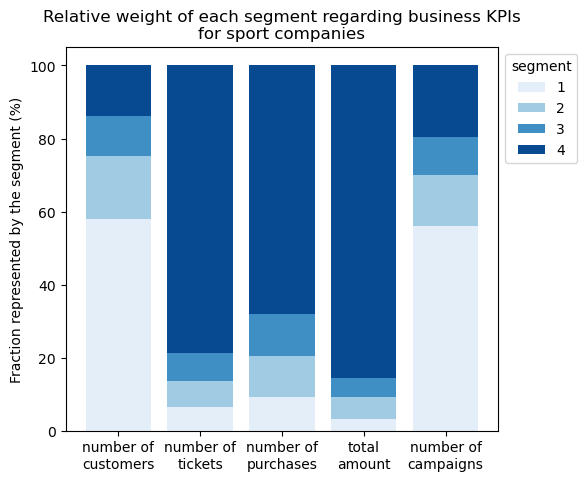

In [35]:
hist_segment_business_KPIs(X_test_business_fig, "segment", "size", *business_var)

In [13]:
activity =  "sport"
PATH = f"projet-bdc2324-team1/Output_marketing_personae_analysis/{activity}/"

file_name = "segments_business_KPIs_" + activity
FILE_PATH_OUT_S3 = PATH + file_name + ".csv"

FILE_PATH_OUT_S3

'projet-bdc2324-team1/Output_marketing_personae_analysis/sport/segments_business_KPIs_sport.csv'

In [24]:
def save_file_s3_mp(File_name, type_of_activity):
    image_buffer = io.BytesIO()
    plt.savefig(image_buffer, format='png')
    image_buffer.seek(0)
    PATH = f"projet-bdc2324-team1/Output_marketing_personae_analysis/{type_of_activity}/"
    FILE_PATH_OUT_S3 = PATH + File_name + type_of_activity + '.png'
    with fs.open(FILE_PATH_OUT_S3, 'wb') as s3_file:
        s3_file.write(image_buffer.read())
    plt.close()

In [94]:
# save to Minio

activity =  "sport"
PATH = f"projet-bdc2324-team1/Output_marketing_personae_analysis/{activity}/"

file_name = "segments_business_KPI_" + activity
# file_name = "segments_business_KPIs_" + activity
FILE_PATH_OUT_S3 = PATH + file_name + ".png"

hist_segment_business_KPIs(X_test_business_fig, "segment", "size", "nb_tickets", 
                           "nb_purchases", "total_amount", "nb_campaigns")

image_buffer = io.BytesIO()
plt.savefig(image_buffer, format='png', dpi=110)
image_buffer.seek(0)

with fs.open(FILE_PATH_OUT_S3, 'wb') as s3_file:
    s3_file.write(image_buffer.read())
plt.close()

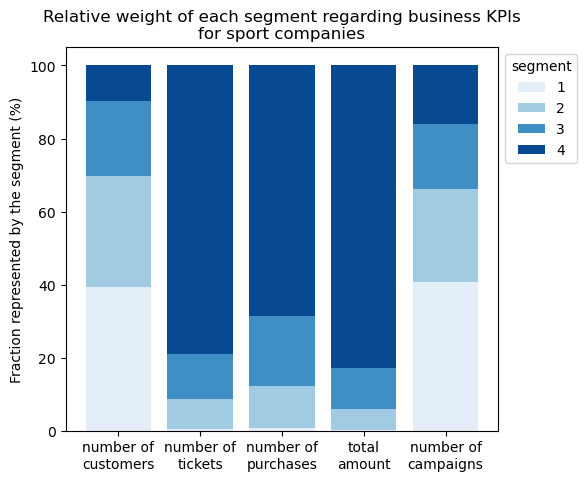

In [91]:
hist_segment_business_KPIs(X_test_business_fig, "segment", "size", "nb_tickets", 
                           "nb_purchases", "total_amount", "nb_campaigns")

In [93]:
# with function

# activity = "sport"

hist_segment_business_KPIs(X_test_business_fig, "segment", "size", "nb_tickets", 
                           "nb_purchases", "total_amount", "nb_campaigns")

save_file_s3_mp(File_name = "segments_business_KPIs_", type_of_activity = type_of_activity)

## 2. Spider plot summarizing sociodemographic characteristics and purchasing behaviour

In [41]:
def df_segment_mp(df, segment, gender_female, gender_male, gender_other, country_fr, age) :
    df_mp = df.groupby(segment)[[gender_female, gender_male, gender_other, country_fr, age]].mean().reset_index()
    # df_mp.insert(3, "share_known_gender", df_mp[gender_female]+df_mp[gender_male])
    df_mp.insert(4, "share_of_women", df_mp[gender_female]/(df_mp[gender_female]+df_mp[gender_male]))
    return df_mp

In [40]:
# description of marketing personae

X_test_segment_mp = X_test_segment.groupby("segment")[['gender_female', 'gender_male', 'gender_other', 'country_fr']].mean().reset_index()
# X_test_segment_mp.insert(3, "share_known_gender", X_test_segment_mp["gender_female"]+X_test_segment_mp["gender_male"])
X_test_segment_mp.insert(4, "share_of_women", X_test_segment_mp["gender_female"]/(X_test_segment_mp["gender_female"]+X_test_segment_mp["gender_male"]))
X_test_segment_mp

segment  gender_female  gender_male  gender_other  share_of_women  \
0       1       0.234460     0.419216      0.346324        0.358679   
1       2       0.295031     0.539591      0.165378        0.353490   
2       3       0.232354     0.583174      0.184472        0.284912   
3       4       0.200692     0.674637      0.124671        0.229276   

   country_fr  
0    0.511056  
1    0.726962  
2    0.633363  
3    0.678772

In [44]:
X_test_segment_mp = df_segment_mp(X_test_segment, "segment", "gender_female", 
                                  "gender_male", "gender_other", "country_fr", "age")
X_test_segment_mp

segment  gender_female  gender_male  gender_other  share_of_women  \
0       1       0.234460     0.419216      0.346324        0.358679   
1       2       0.295031     0.539591      0.165378        0.353490   
2       3       0.232354     0.583174      0.184472        0.284912   
3       4       0.200692     0.674637      0.124671        0.229276   

   country_fr        age  
0    0.511056  40.652136  
1    0.726962  36.204792  
2    0.633363  37.533425  
3    0.678772  39.665371

In [46]:
# purchasing behaviour

# X_test_segment["share_tickets_internet"] = X_test_segment["nb_tickets_internet"]/X_test_segment["nb_tickets"]
X_test_segment["share_campaigns_opened"] = X_test_segment["nb_campaigns_opened"]/X_test_segment["nb_campaigns"]
X_test_segment_pb = X_test_segment.groupby("segment")[["prop_purchases_internet", "share_campaigns_opened", "opt_in"]].mean().reset_index()
X_test_segment_pb

segment  prop_purchases_internet  share_campaigns_opened    opt_in
0       1                 0.090439                0.141985  0.587075
1       2                 0.502232                0.271623  0.111611
2       3                 0.681753                0.299255  0.122377
3       4                 0.528249                0.349811  0.178660

In [33]:
def df_segment_pb (df, segment, nb_tickets_internet, nb_tickets, nb_campaigns_opened, nb_campaigns, opt_in,
                  time_to_open) :
    df_used = df
    df_used["share_tickets_internet"] = df_used[nb_tickets_internet]/df_used[nb_tickets]
    df_used["share_campaigns_opened"] = df_used[nb_campaigns_opened]/df_used[nb_campaigns]
    df_pb = df_used.groupby(segment)[["share_tickets_internet", "share_campaigns_opened", 
                                      opt_in, time_to_open]].mean().reset_index()
    df_pb["time_to_open_med"] = df_used.groupby(segment)[[time_to_open]].apply(lambda x: x.dropna().median()).values
    return df_pb

In [35]:
# add : variable time to open

from datetime import timedelta

def str_duration_to_hours(duration_str):
    parts = duration_str.split()
    days = int(parts[0]) if len(parts) > 1 else 0
    time_parts = parts[-1].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2].split('.')[0])
    total_hours = days * 24 + hours + minutes / 60 + seconds / 3600
    return total_hours

# Exemple d'utilisation :
duration_str = '2 days 01:39:12.750000'

hours = str_duration_to_hours(duration_str)
print("Durée totale en heures :", hours)


Durée totale en heures : 49.65333333333333


In [36]:
# def of the variable time_to_open

X_test_segment["time_to_open"] = dataset_test["time_to_open"].apply(lambda x : np.nan if pd.isna(x) else str_duration_to_hours(x))
X_test_segment.groupby("segment")["time_to_open"].median()

segment
1     6.418056
2     8.031389
3    13.037500
4    15.197500
Name: time_to_open, dtype: float64

In [37]:
X_test_segment_pb = df_segment_pb(X_test_segment, "segment", "nb_tickets_internet", "nb_tickets", 
                                  "nb_campaigns_opened", "nb_campaigns", "opt_in", "time_to_open")
X_test_segment_pb

segment  share_tickets_internet  share_campaigns_opened    opt_in  \
0       1                0.527270                0.136565  0.730064   
1       2                0.629648                0.194240  0.275860   
2       3                0.654488                0.292206  0.054260   
3       4                0.606618                0.370733  0.127051   

   time_to_open  time_to_open_med  
0     56.785498          6.418056  
1     56.349272          8.031389  
2     57.847390         13.037500  
3     57.567684         15.197500

In [49]:
#X_test_segment_caract = pd.concat([X_test_segment_pb.drop("time_to_open", axis=1), X_test_segment_mp[['share_known_gender', 'share_of_women', 'country_fr', 'age']]], axis=1)
X_test_segment_caract = pd.concat([X_test_segment_pb, X_test_segment_mp[[ 'share_of_women', 'age']]], axis=1)
X_test_segment_caract

segment  prop_purchases_internet  share_campaigns_opened    opt_in  \
0       1                 0.090439                0.141985  0.587075   
1       2                 0.502232                0.271623  0.111611   
2       3                 0.681753                0.299255  0.122377   
3       4                 0.528249                0.349811  0.178660   

   share_of_women        age  
0        0.358679  40.652136  
1        0.353490  36.204792  
2        0.284912  37.533425  
3        0.229276  39.665371

In [216]:
X_test_segment_caract.loc[:,"share_tickets_internet":].max()

share_tickets_internet     0.654488
share_campaigns_opened     0.370733
opt_in                     0.730064
time_to_open_med          15.197500
share_known_gender         0.903085
share_of_women             0.571869
country_fr                 0.805862
dtype: float64

In [50]:
# def d'une fonction associée - KEEP THIS !!!

def radar_mp_plot(df, categories, index, var_not_perc) :
    categories = categories

    # true values are used to print the true value in parenthesis
    tvalues = list(df.loc[index,categories]) 

    max_values = df[categories].max()

    # values are true values / max among the 4 segments, allows to 
    # put values in relation with the values for other segments
    # if the point has a maximal abscisse it means that value is maximal for the segment considered
    # , event if not equal to 1
    
    values = list(df.loc[index,categories]/max_values)
                  
    # values normalized are used to adjust the value around the circle
    # for instance if the maximum of values is equal to 0.8, we want the point to be 
    # at 8/10th of the circle radius, not at the edge 
    values_normalized = [ max(values) * elt for elt in values]

    # Nb of categories
    num_categories = len(categories)
    
    angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
    
    # Initialize graphic
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # we have to draw first a transparent line (alpha=0) of values to adjust the radius of the circle
    # which is based on max(value)
    ax.plot(angles + angles[:1], values + values[:1], color='skyblue', alpha=0, linewidth=1.5)
    ax.plot(angles + angles[:1], values_normalized + values_normalized[:1], color='black', alpha = 0.5, linewidth=1.2)
    
    # fill the sector
    ax.fill(angles, values_normalized, color='orange', alpha=0.4)
    
    # labels
    ax.set_yticklabels([])
    ax.set_xticks(angles)

    # define tick labels
    values_printed = [str(round(tvalues[i],2)) if categories[i] in var_not_perc else f"{round(100 * tvalues[i],2)}%" for i in range(len(categories))]
    # ticks = [categories[i].replace("_"," ") + f"\n({round(100 * tvalues[i],2)}%)" for i in range(len(categories))]
    ticks = [categories[i].replace("_"," ") + f"\n({values_printed[i]})" for i in range(len(categories))]

    ax.set_xticklabels(ticks, color="black")
    
    ax.spines['polar'].set_visible(False)
    
    plt.title(f'Characteristics of the segment {index+1}\n')
    
    # plt.show()

In [229]:
var_not_perc = ["time_to_open_med", "age"]

tvalues = list(X_test_segment_caract.loc[3,categories]) 

values_printed = [str(round(tvalues[i],2)) if categories[i] in var_not_perc else f"{round(100 * tvalues[i],2)}%" for i in range(len(categories))]
values_printed

['60.66%', '37.07%', '12.71%', '15.2', '20.82%', '63.9%']

In [41]:
list(X_test_segment_caract.drop(["segment", "share_known_gender"], axis=1).columns)


['share_tickets_internet',
 'share_campaigns_opened',
 'opt_in',
 'time_to_open_med',
 'share_of_women',
 'country_fr',
 'age']

In [52]:
X_test_segment_caract

segment  prop_purchases_internet  share_campaigns_opened    opt_in  \
0       1                 0.090439                0.141985  0.587075   
1       2                 0.502232                0.271623  0.111611   
2       3                 0.681753                0.299255  0.122377   
3       4                 0.528249                0.349811  0.178660   

   share_of_women        age  
0        0.358679  40.652136  
1        0.353490  36.204792  
2        0.284912  37.533425  
3        0.229276  39.665371

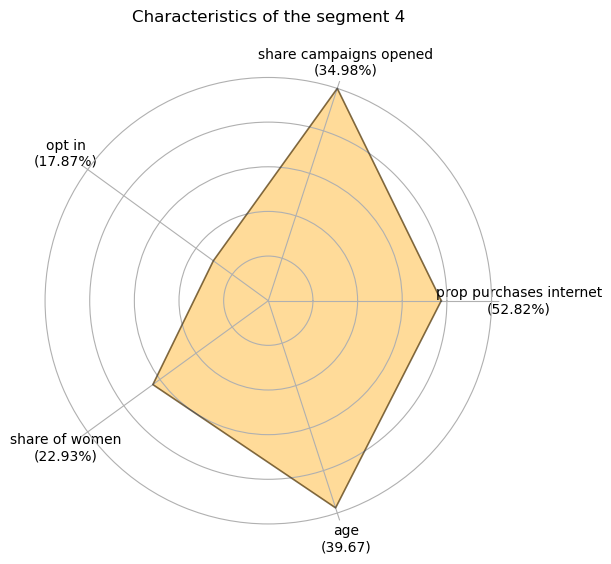

In [53]:
var_not_perc = ["age"]

categories = list(X_test_segment_caract.drop(["segment"], axis=1).columns)
#for i in range(4) :
#    radar_mp_plot(df=X_test_segment_caract, categories=categories, index=i)
radar_mp_plot(df=X_test_segment_caract, categories=categories, index=3, var_not_perc=var_not_perc)

In [739]:
# export to MinIo

activity =  "sport"
PATH = f"projet-bdc2324-team1/Output_marketing_personae_analysis/{activity}/"

file_name = "spider_chart_" + activity + "_sgt_" + str(index)
FILE_PATH_OUT_S3 = PATH + file_name + ".csv"


radar_mp_plot(df=X_test_segment_caract, categories=categories, index=3)

image_buffer = io.BytesIO()
plt.savefig(image_buffer, format='png')
image_buffer.seek(0)

with fs.open(FILE_PATH_OUT_S3, 'wb') as s3_file:
    s3_file.write(image_buffer.read())
plt.close()

SyntaxError: invalid syntax (4005960846.py, line 6)

In [740]:
activity =  "sport"
PATH = f"projet-bdc2324-team1/Output_marketing_personae_analysis/{activity}/"

file_name = "spider_chart_" + activity + "_sgt_" + str(index)
FILE_PATH_OUT_S3 = PATH + file_name + ".csv"
FILE_PATH_OUT_S3

'projet-bdc2324-team1/Output_marketing_personae_analysis/sport/spider_chart_sport_sgt_3.csv'

In [57]:
# general function to have the 4 radars in one plot

def radar_mp_plot_all(df, categories, var_not_perc) :
    
    nb_segments = df.shape[0]
    categories = categories

    # Initialize graphic
    fig, ax = plt.subplots(2,2, figsize=(20, 21), subplot_kw=dict(polar=True))
    
    for index in range(nb_segments) :
        row = index // 2  # Division entière pour obtenir le numéro de ligne
        col = index % 2 
            
        # df = X_test_segment_caract
    
        # true values are used to print the true value in parenthesis
        tvalues = list(df.loc[index,categories]) 
        
        max_values = df[categories].max()
        
        # values are true values / max among the 4 segments, allows to 
        # put values in relation with the values for other segments
        # if the point has a maximal abscisse it means that value is maximal for the segment considered
        # , event if not equal to 1
        
        values = list(df.loc[index,categories]/max_values)
                      
        # values normalized are used to adjust the value around the circle
        # for instance if the maximum of values is equal to 0.8, we want the point to be 
        # at 8/10th of the circle radius, not at the edge 
        values_normalized = [ max(values) * elt for elt in values]
        
        # Nb of categories
        num_categories = len(categories)

        angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
    
        # we have to draw first a transparent line (alpha=0) of values to adjust the radius of the circle
        # which is based on max(value)
        ax[row, col].plot(angles + angles[:1], values + values[:1], color='skyblue', alpha=0, linewidth=1.5)
        ax[row, col].plot(angles + angles[:1], values_normalized + values_normalized[:1], color='black', alpha = 0.5, linewidth=1.2)
        
        # fill the sector
        ax[row, col].fill(angles, values_normalized, color='orange', alpha=0.4, label = index)
        
        # labels
        ax[row, col].set_yticklabels([])
        ax[row, col].set_xticks(angles)
        
        # define the ticks
        values_printed = [str(round(tvalues[i],2)) if categories[i] in var_not_perc else f"{round(100 * tvalues[i],2)}%" for i in range(len(categories))]

        # ticks = [categories[i].replace("_"," ") + f"\n({round(100 * tvalues[i],2)}%)" for i in range(len(categories))]
        ticks = [categories[i].replace("_"," ") + f"\n({values_printed[i]})" for i in range(len(categories))]
        ax[row, col].set_xticklabels(ticks, color="black", size = 20)
        
        ax[row, col].spines['polar'].set_visible(False)
        
        # plt.title(f'Characteristics of the segment {index+1}\n')
        ax[row, col].set_title(f'Segment {index+1}\n', size = 24)
        
    fig.suptitle(f"Characteristics of marketing personae of {type_of_activity} companies", size=32)

    plt.tight_layout()

    # plt.show()

In [45]:
X_test_segment_caract

segment  share_tickets_internet  share_campaigns_opened    opt_in  \
0       1                0.527270                0.136565  0.730064   
1       2                0.629648                0.194240  0.275860   
2       3                0.654488                0.292206  0.054260   
3       4                0.606618                0.370733  0.127051   

   time_to_open_med  share_known_gender  share_of_women  country_fr        age  
0          6.418056            0.523129        0.571869    0.339959  41.298584  
1          8.031389            0.855391        0.182710    0.805862  39.293163  
2         13.037500            0.903085        0.323075    0.701258  35.176503  
3         15.197500            0.864373        0.208231    0.638972  41.320841

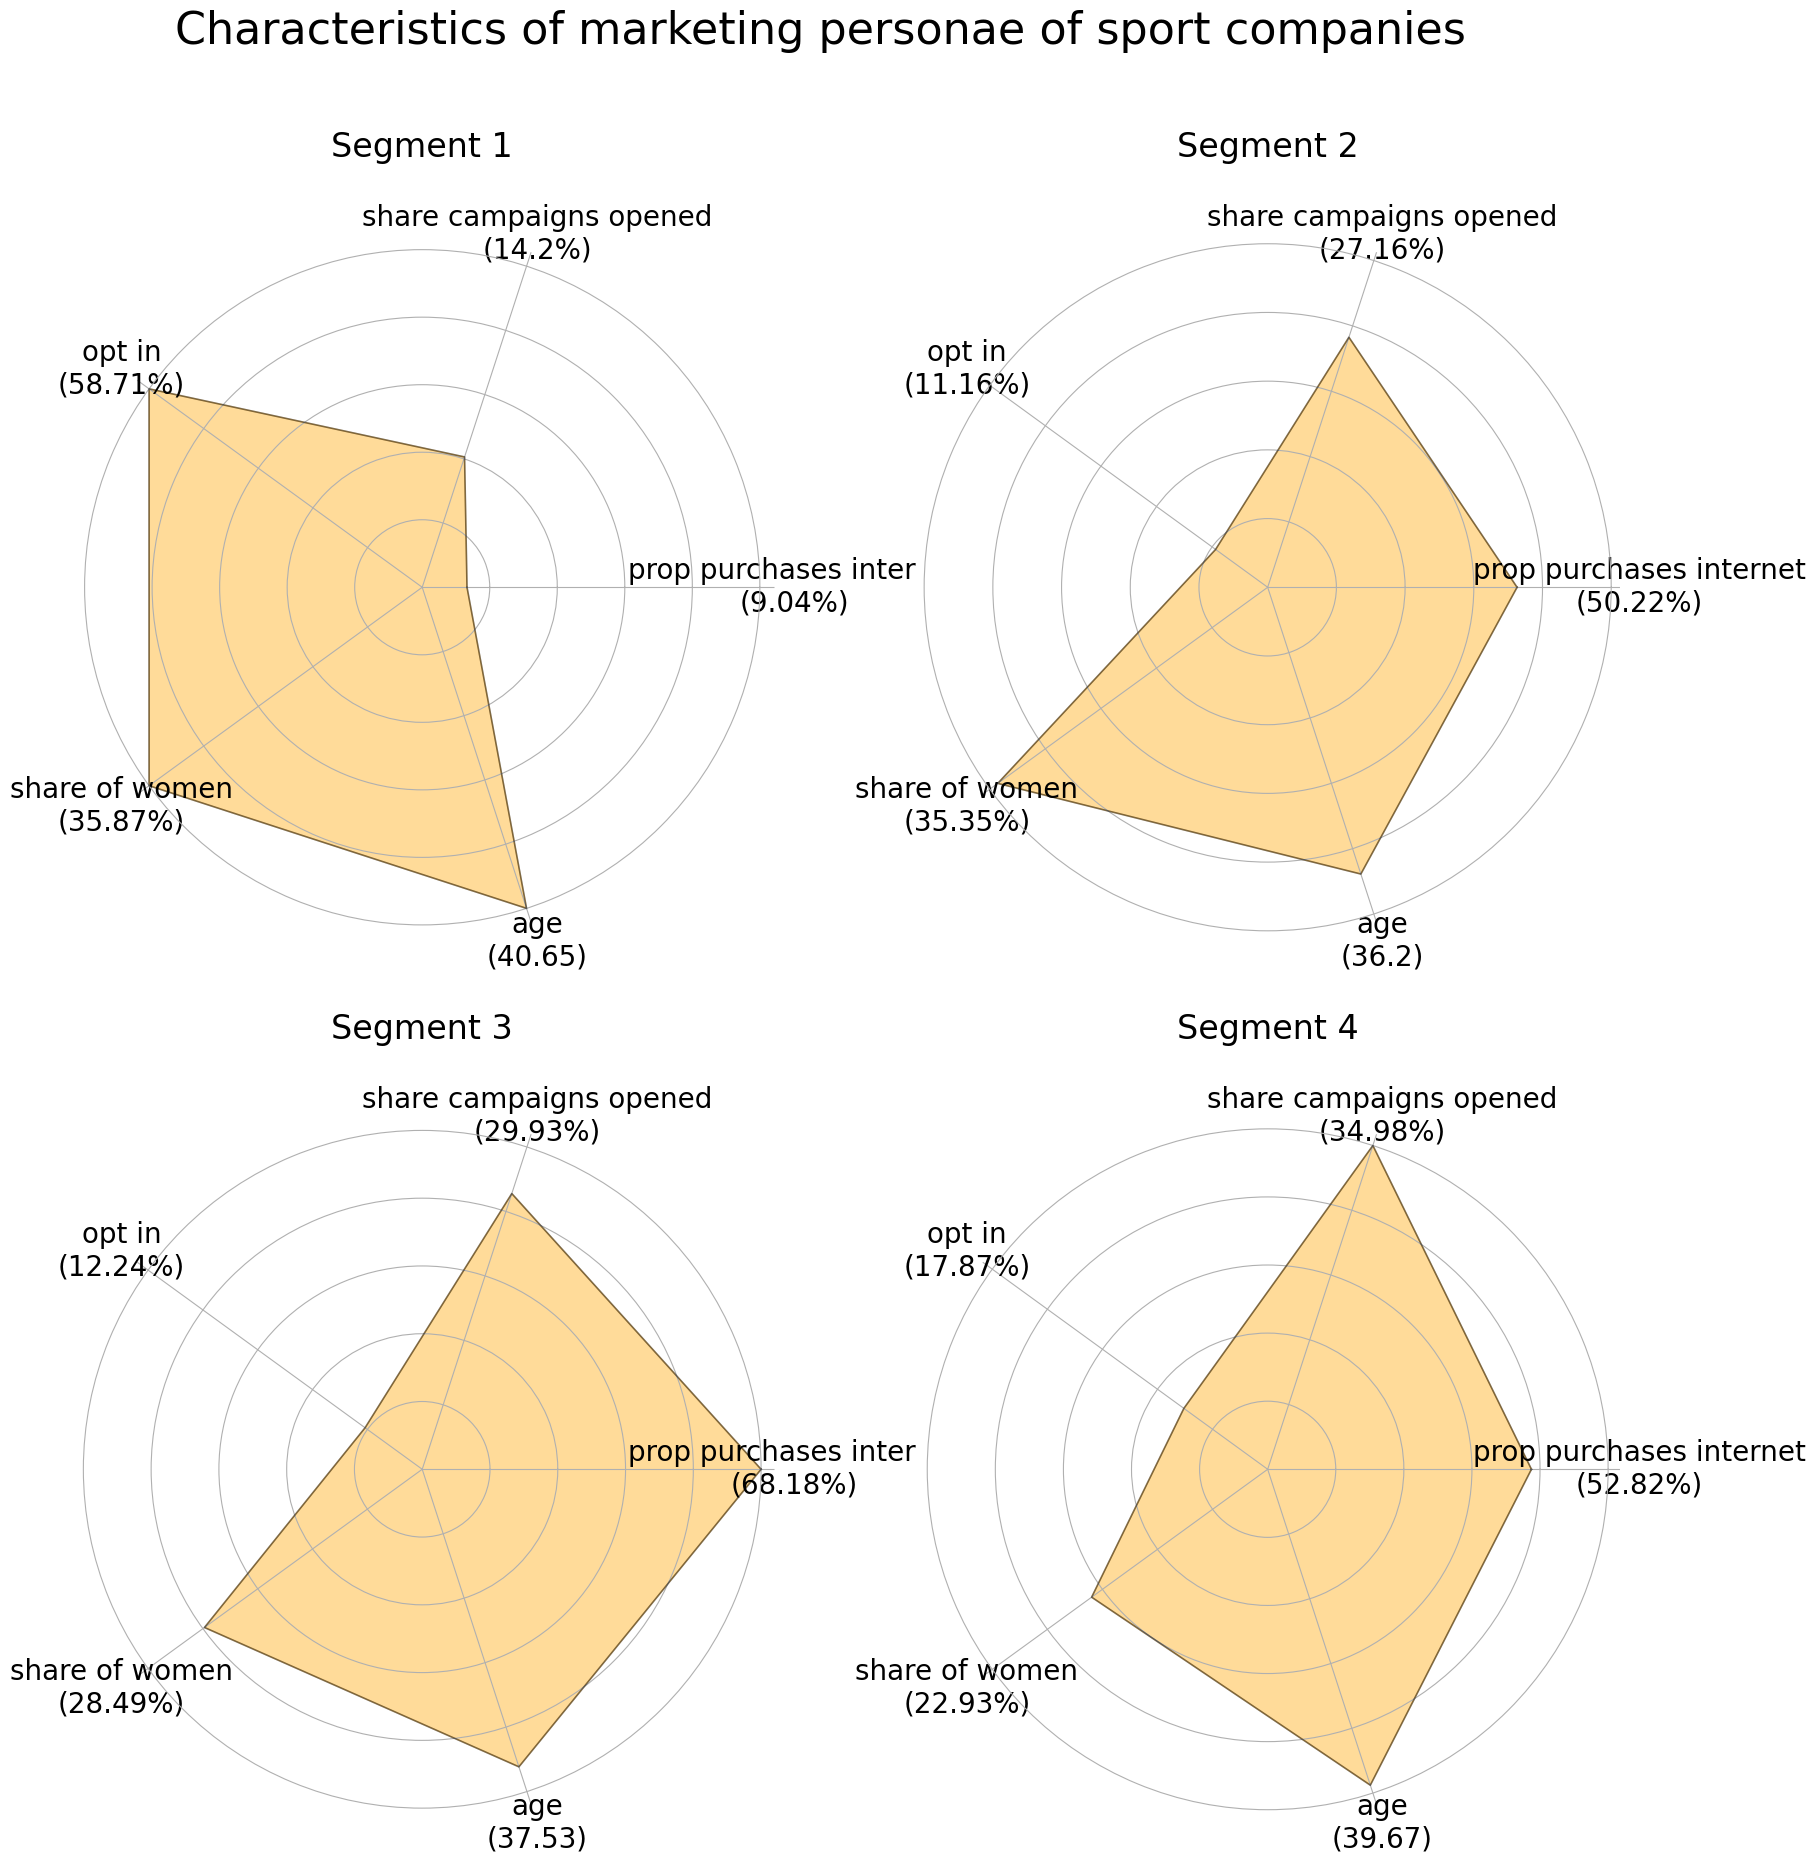

In [58]:
categories = list(X_test_segment_caract.drop(["segment"], axis=1).columns)
var_not_perc = ["age"]
radar_mp_plot_all(df=X_test_segment_caract, categories=categories, var_not_perc=var_not_perc)

In [97]:
# export to MinIo

# activity =  "sport"
# PATH = f"projet-bdc2324-team1/Output_marketing_personae_analysis/{activity}/"

file_name = "spider_chart_all_" + activity
FILE_PATH_OUT_S3 = PATH + file_name + ".png"

radar_mp_plot_all(df=X_test_segment_caract, categories=categories)

image_buffer = io.BytesIO()
plt.savefig(image_buffer, format='png', dpi=110)
image_buffer.seek(0)

with fs.open(FILE_PATH_OUT_S3, 'wb') as s3_file:
    s3_file.write(image_buffer.read())
plt.close()

In [69]:
def radar_mp_plot_all(df, type_of_activity) :
    
    # table summarizing variables relative to marketing personae
    df_mp = df.groupby("segment")[["gender_female", "gender_male", "gender_other", "age"]].mean().reset_index()
    #df_mp.insert(3, "share_known_gender", df_mp["gender_female"]+df_mp["gender_male"])
    df_mp.insert(4, "share_of_women", df_mp["gender_female"]/(df_mp["gender_female"]+df_mp["gender_male"]))

    # table relative to purchasing behaviour
    df_pb = df.groupby("segment")[["prop_purchases_internet", "taux_ouverture_mail", "opt_in"]].mean().reset_index()

    # concatenation of tables to prepare the plot
    df_used = pd.concat([df_pb, df_mp[[ 'share_of_women', 'age']]], axis=1)

    # visualization
    nb_segments = df_used.shape[0]
    categories = list(df_used.drop("segment", axis=1).columns)

    var_not_perc = ["age"]

    # Initialize graphic
    fig, ax = plt.subplots(2,2, figsize=(20, 20), subplot_kw=dict(polar=True))
    
    for index in range(nb_segments) :
        row = index // 2  # Division entière pour obtenir le numéro de ligne
        col = index % 2 
    
        # true values are used to print the true value in parenthesis
        tvalues = list(df_used.loc[index,categories]) 
        
        max_values = df_used[categories].max()
        
        # values are true values / max among the 4 segments, allows to 
        # put values in relation with the values for other segments
        # if the point has a maximal abscisse it means that value is maximal for the segment considered
        # , event if not equal to 1

        values = list(df_used.loc[index,categories]/max_values)
                          
        # values normalized are used to adjust the value around the circle
        # for instance if the maximum of values is equal to 0.8, we want the point to be 
        # at 8/10th of the circle radius, not at the edge 
        values_normalized = [ max(values) * elt for elt in values]
        
        # Nb of categories
        num_categories = len(categories)
    
        angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
    
        # we have to draw first a transparent line (alpha=0) of values to adjust the radius of the circle
        # which is based on max(value)
        ax[row, col].plot(angles + angles[:1], values + values[:1], color='skyblue', alpha=0, linewidth=1.5)
        ax[row, col].plot(angles + angles[:1], values_normalized + values_normalized[:1], color='black', alpha = 0.5,
                          linewidth=1.2)
        
        # fill the sector
        ax[row, col].fill(angles, values_normalized, color='orange', alpha=0.4, label = index)
        
        # labels
        ax[row, col].set_yticklabels([])
        ax[row, col].set_xticks(angles)

        # define the ticks
        values_printed = [round(tvalues[i],2) if categories[i] in var_not_perc else f"{round(100 * tvalues[i],2)}%" for i in range(len(categories))]       
        print(values_printed)
        ticks = [categories[i].replace("_"," ") + f"\n({values_printed[i]})" for i in range(len(categories))]
        ax[row, col].set_xticklabels(ticks, color="black", size = 20)

        ax[row, col].spines['polar'].set_visible(False)
        
        ax[row, col].set_title(f'Segment {index+1}\n', size = 24)
        
    fig.suptitle(f"Characteristics of marketing personae of {type_of_activity} companies", size=32)

    plt.tight_layout()
    # plt.show()

['9.04%', '12.82%', '58.71%', '35.87%', 40.65]
['50.22%', '19.06%', '11.16%', '35.35%', 36.2]
['68.18%', '19.45%', '12.24%', '28.49%', 37.53]
['52.82%', '20.28%', '17.87%', '22.93%', 39.67]


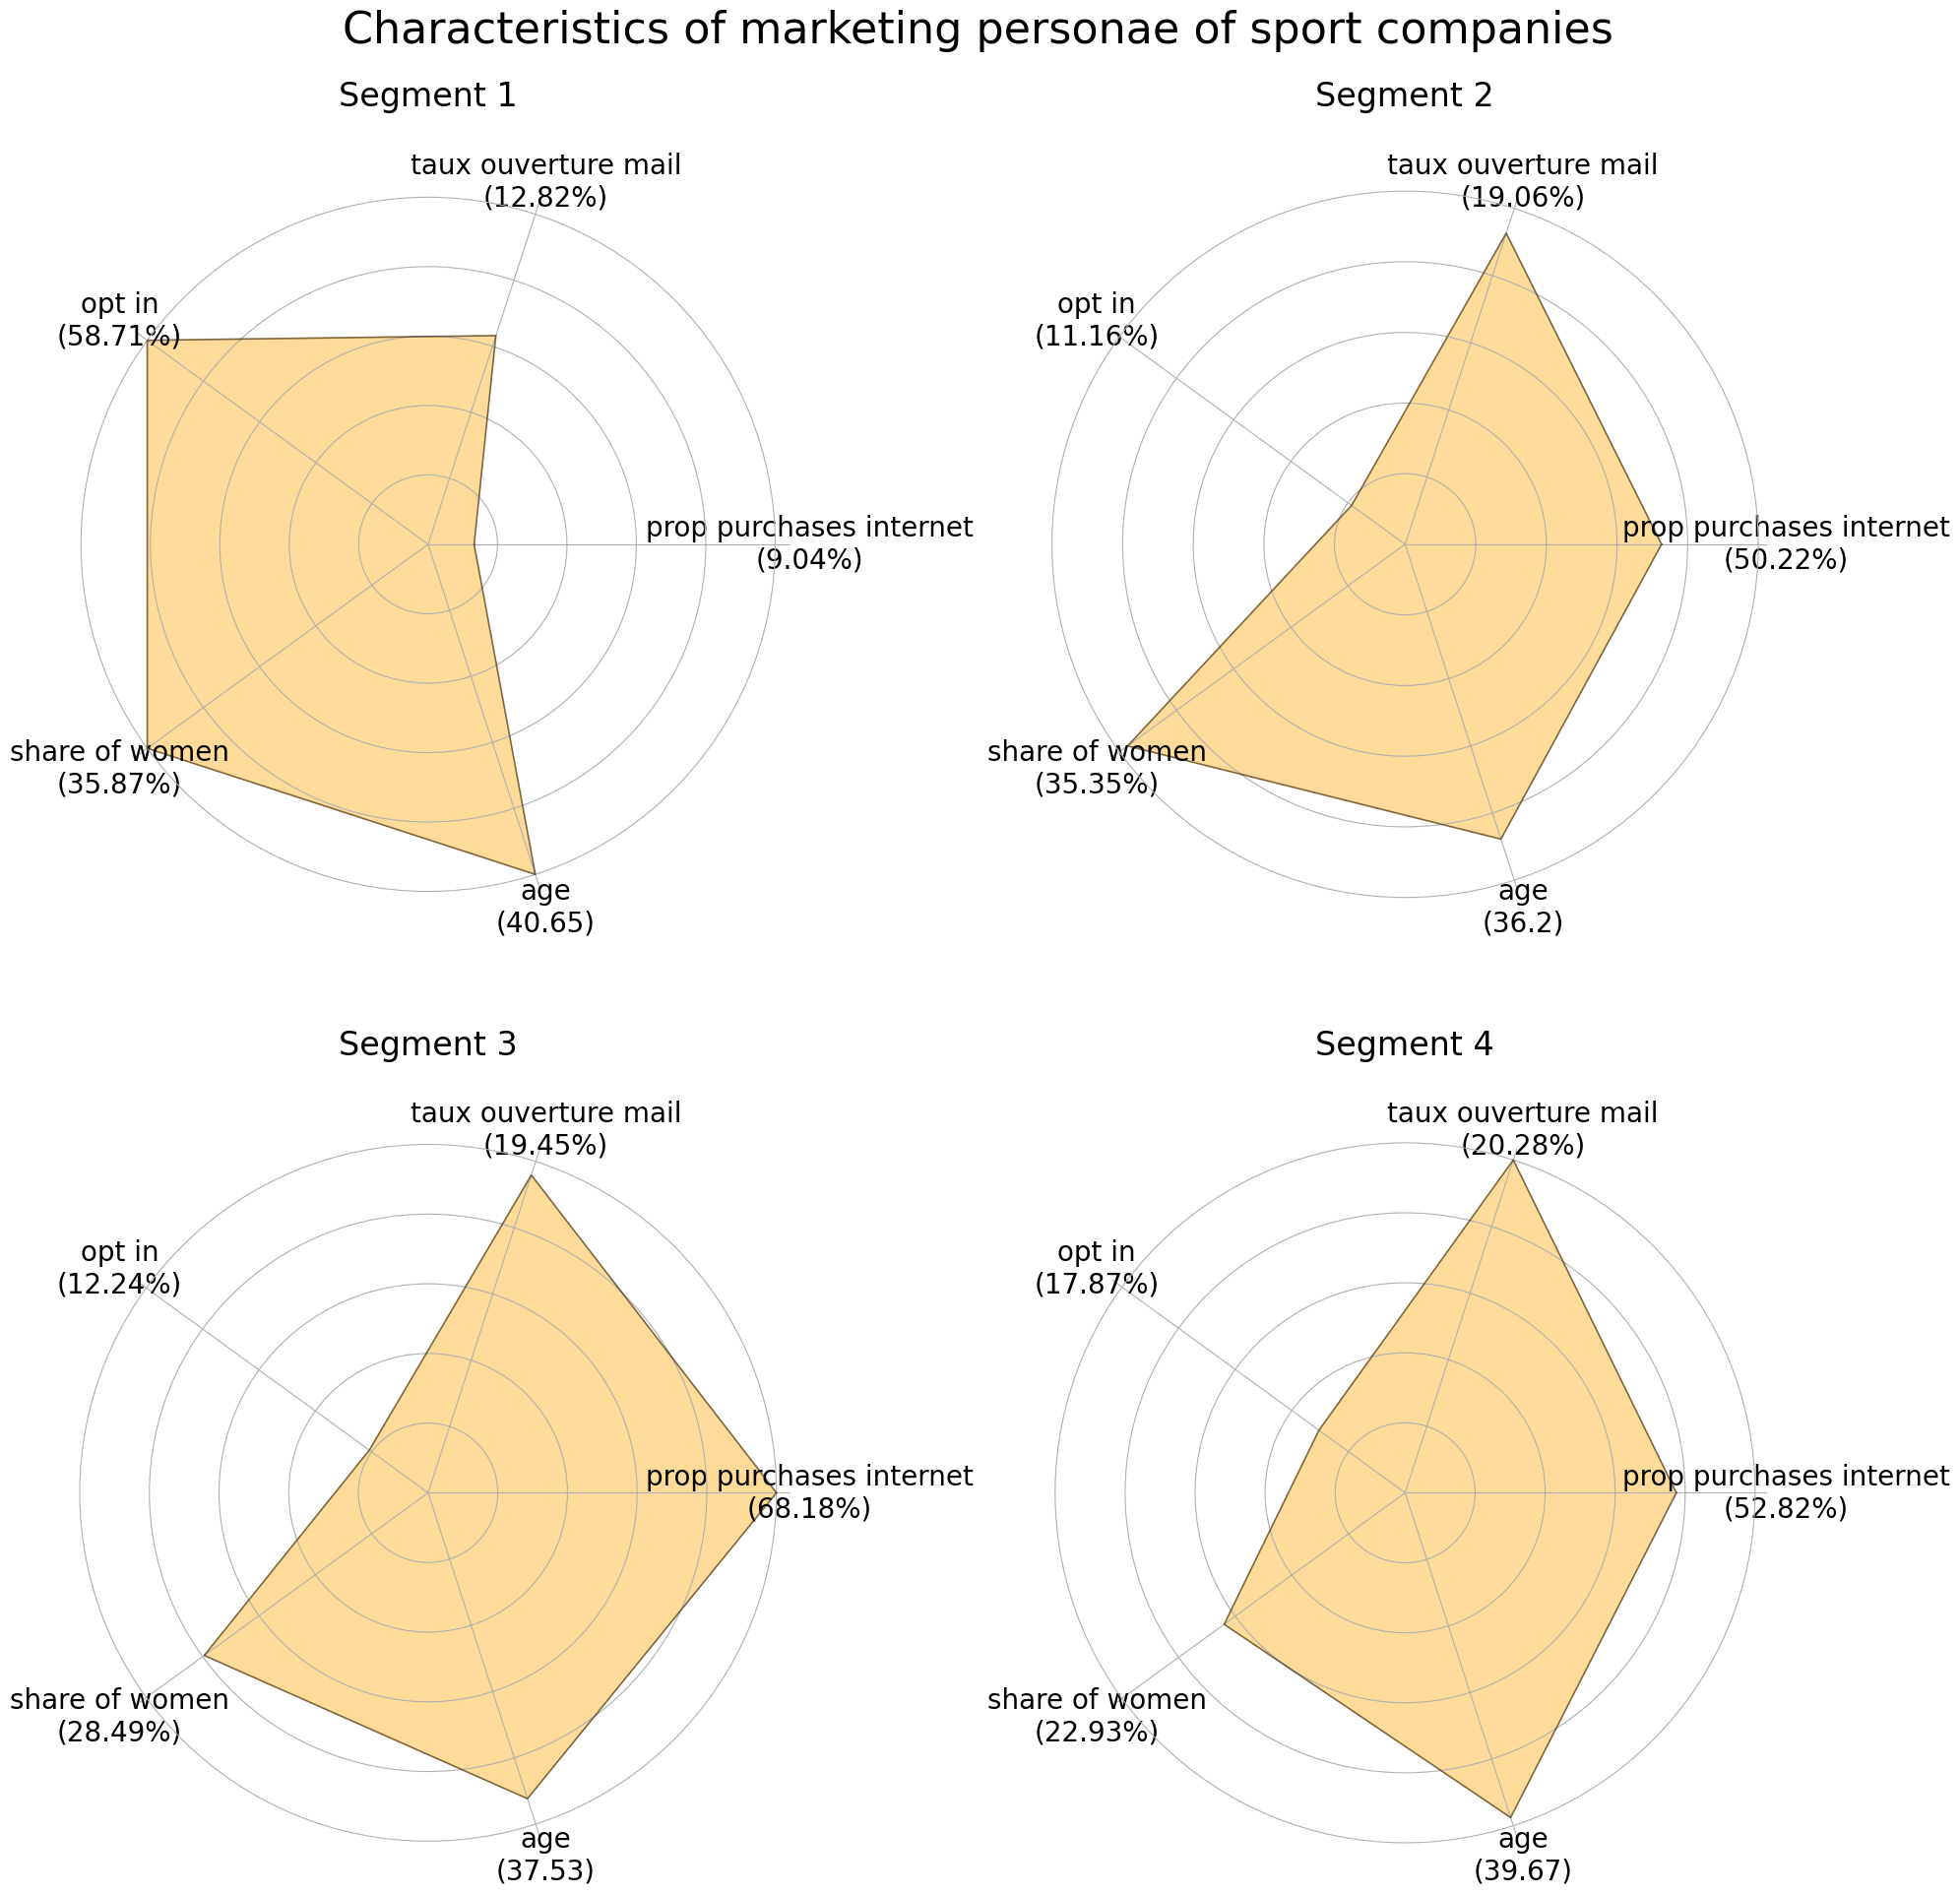

In [70]:
radar_mp_plot_all(X_test_segment, type_of_activity)

## --- end of the main part --- here are just some attempts --- ##

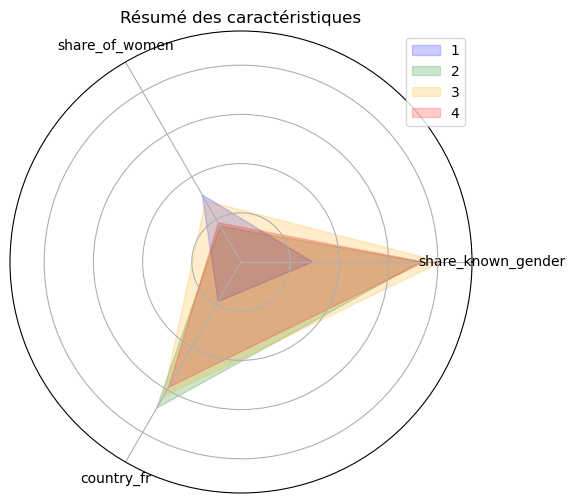

In [489]:
colors = plt.cm.Blues(np.linspace(0.1, 0.9, 4)) 
colors = ["blue", "green", "orange", "red"]

# Initialisez le graphique en étoile
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i in range(4) :

    # Caractéristiques et valeurs associées (exemple)
    categories = ['share_known_gender', 'share_of_women', 'country_fr']
    values = list(X_test_segment_mp.loc[i,categories])  # Exemple de valeurs, ajustez selon vos données
    
    values_normalized = [ max(values) * elt for elt in values]
    
    # Nombre de caractéristiques
    num_categories = len(categories)
    
    # Créer un angle pour chaque axe
    angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
    
    
    # Tracer uniquement le contour du polygone
    ax.plot(angles + angles[:1], values + values[:1], color='skyblue', alpha=0, linewidth=1.5)
    # ax.plot(angles + angles[:1], values_normalized + values_normalized[:1], color='blue', alpha = 0.3, linewidth=1.5)
    
    # Remplir le secteur central avec une couleur
    ax.fill(angles, values_normalized, color=colors[i], alpha=0.2, label = str(i+1))

# Étiqueter les axes
ax.set_yticklabels([])
ax.set_xticks(angles)
ax.set_xticklabels(categories)
ax.legend()

# Titre du graphique
plt.title('Résumé des caractéristiques')

# Afficher le graphique
plt.show()

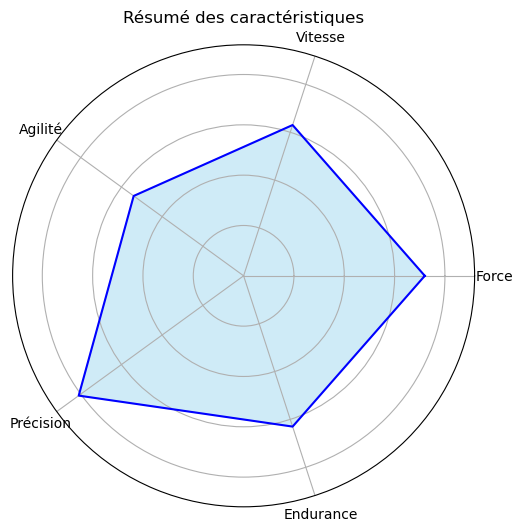

In [301]:
# KEEP THIS CODE !!

# Caractéristiques et valeurs associées (exemple)
categories = ['Force', 'Vitesse', 'Agilité', 'Précision', 'Endurance']
values = [8, 7, 6, 9, 7]  # Exemple de valeurs, ajustez selon vos données

# Plage de valeurs maximales pour chaque caractéristique
max_range = [20, 20, 20, 20, 20]

values_normalized = [2 * max(values) * x / y for x, y in zip(values, max_range)]

# Nombre de caractéristiques
num_categories = len(categories)

# Créer un angle pour chaque axe
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

# Initialisez le graphique en étoile
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Tracer uniquement le contour du polygone
ax.plot(angles + angles[:1], values + values[:1], color='skyblue', alpha=0, linewidth=1.5)
ax.plot(angles + angles[:1], values_normalized + values_normalized[:1], color='blue', linewidth=1.5)

# Remplir le secteur central avec une couleur
ax.fill(angles, values_normalized, color='skyblue', alpha=0.4)

# Étiqueter les axes
ax.set_yticklabels([])
ax.set_xticks(angles)
ax.set_xticklabels(categories)

# Titre du graphique
plt.title('Résumé des caractéristiques')

# Afficher le graphique
plt.show()


In [149]:
def radar_chart(values, categories, segment) :
    # Caractéristiques et valeurs associées (exemple)
    categories = categories
    values = values  # Exemple de valeurs, ajustez selon vos données
    
    # Nombre de caractéristiques
    num_categories = len(categories)
    
    # Créer un angle pour chaque axe
    angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
    
    # Répéter le premier angle pour fermer la figure
    values += values[:1]
    angles += angles[:1]
    
    # Initialisez le graphique en étoile
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # Tracer les lignes radiales
    ax.fill(angles, values, color='skyblue', alpha=0.4)
    
    # Tracer les points sur les axes radiaux
    ax.plot(angles, values, color='blue', linewidth=2, linestyle='solid')

    # Afficher les valeurs associées sous les noms de variables
    """
    for i, angle in enumerate(angles[:-1]):
        x = angle
        y = values[i] + 0.2  # Ajustez la distance des valeurs par rapport au centre
        plt.text(x, y, str(values[i]), color='black', ha='center', fontsize=10)
        """
    
    # Remplir le secteur central avec une couleur
    # ax.fill(angles, values, color='skyblue', alpha=0.4)

    
    # Étiqueter les axes
    ax.set_yticklabels([])
    #ax.set_xticks(angles[:-1])
    #ax.set_xticklabels(categories, # fontsize=12, ha='right', rotation=45
    #                  )
    # ax.set_xticklabels(categories, fontsize=10, color='black', ha='right')

    labels = [f"{category} = {round(100 *value,2)}%" for category, value in zip(categories, values[:-1])]
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10, color='black', ha='right')
    
    # Titre du graphique
    plt.title(f'Caracteristics of segment {segment}')
    
    # Afficher le graphique
    plt.show()


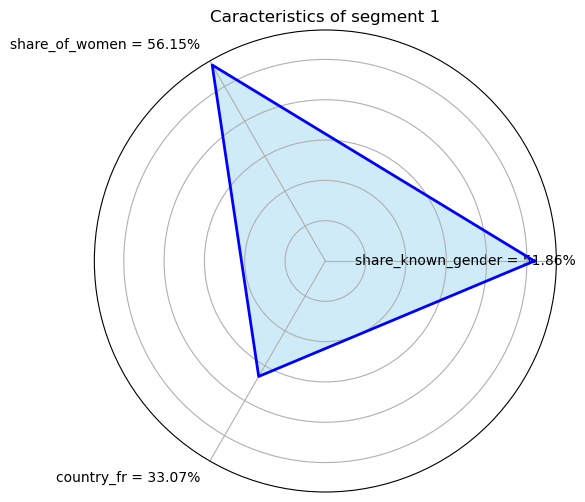

In [150]:
categories= ["share_known_gender","share_of_women","country_fr"]
radar_chart(values=X_test_segment_mp.loc[0,categories].values.tolist(), categories= categories,
            segment = "1")